## Validation and Model Selection

Model evaluation and the tuning of hyperparameters, which are parameters that define the model

In [3]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

- ### Validating Models

One of the most important pieces of machine learning is **model validation**: that is, checking how well your model fits a given dataset. But there are some pitfalls you need to watch out for.

Consider the digits example we've been looking at previously. How might we check how well our model fits the data?

In [6]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

y_pred = knn.predict(X)
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


- ### Validation Sets

Above we made the mistake of testing our data on the same set of data that was used for training. **This is not generally a good idea**. If we optimize our estimator this way, we will tend to **over-fit** the data: that is, we learn the noise.

A better way to test a model is to use a hold-out set which doesn't enter the training (train/test split utility):

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print('Shape of Data :',X_train.shape, X_test.shape)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Result :',"{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

################################################################
## accuracy score
from sklearn.metrics import accuracy_score
print('Accuracy Score :',accuracy_score(y_test, y_pred))
print('Accuracy Score :',knn.score(X_test, y_test))

Shape of Data : (1347, 64) (450, 64)
Result : 446 / 450 correct
Accuracy Score : 0.9911111111111112
Accuracy Score : 0.9911111111111112


Using this, we can ask how this changes as we change the model parameters, in this case the number of neighbors:

In [14]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

1 0.9911111111111112
5 0.9844444444444445
10 0.9777777777777777
20 0.9622222222222222
30 0.9644444444444444


- ### Cross-Validation

2-fold cross-validation, where we split the sample in half and perform the validation twice

In [20]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=10)
print(cv.mean())

print('Wie:')
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.9761493860252022
Wie:
0.9832962138084632
0.982202447163515


- #### K-fold Cross-Validation

$K$-fold cross-validation, where we split the data into $K$ chunks and perform $K$ fits, where each chunk gets a turn as the validation set.

We can do this by changing the ``cv`` parameter above. Let's do 10-fold cross-validation:

In [17]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=10)

array([0.93513514, 0.99453552, 0.97237569, 0.98888889, 0.96089385,
       0.98882682, 0.99441341, 0.98876404, 0.97175141, 0.96590909])

## Overfitting, Underfitting and Model Selection

Selecting the optimal model
for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.

Of core importance is the following question:

**If our estimator is underperforming, how should we move forward?**

- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

The answer is often counter-intuitive.  In particular, **Sometimes using a
more complicated model will give _worse_ results.**  Also, **Sometimes adding
training data will not improve your results.**  The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

- ### Illustration of the Bias-Variance Tradeoff

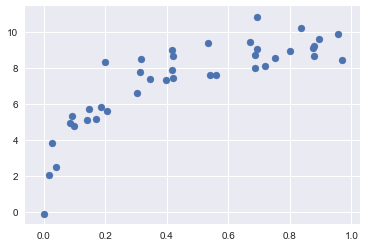

In [36]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

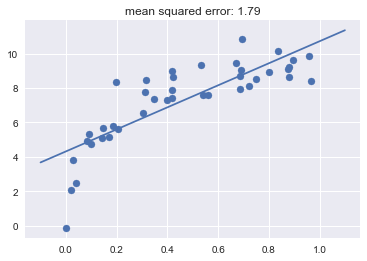

In [37]:
## Linear Regression Function -- Under Fitting
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

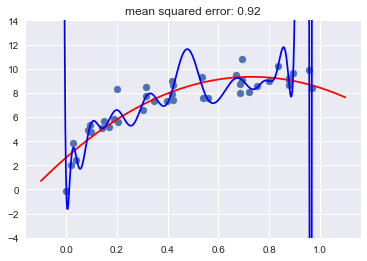

In [40]:
## Polynomial Features -- Gut mit 2 Ord / Over Fitting mit 30 Ord
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test,'r')
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));


model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)
plt.plot(X_test.ravel(), y_test,'b')
plt.ylim(-4, 14);

- ### Detecting Over-fitting with Validation Curves

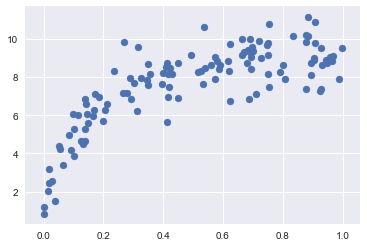

In [50]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [45]:
from sklearn.model_selection import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

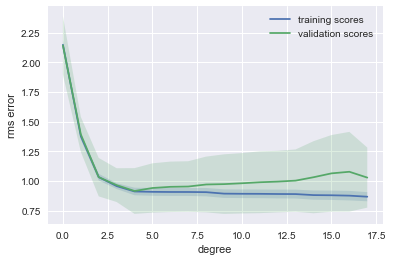

In [46]:
## Validation Curves
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

Notice the trend here, which is common for this type of plot.

1. For a small model complexity, the training error and validation error are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

Here's our best-fit model according to the cross-validation:

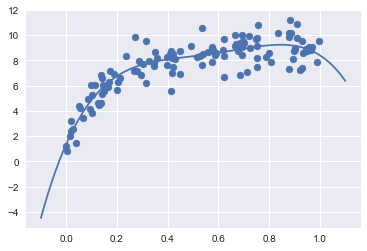

In [47]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

- ### Detecting Data Sufficiency with Learning Curves

As you might guess, the exact turning-point of the tradeoff between bias and variance is **highly dependent on the number of training points used**.  Here we'll illustrate the use of *learning curves*, which display this property.

The idea is to plot the mean-squared-error for the training and test set as a function of *Number of Training Points*

In [62]:
X.shape, y.shape

((120, 1), (120,))

[ 4  9 14 19 24 28 33 38 43 47 52 57 62 67 72 76 81 86 91 96]


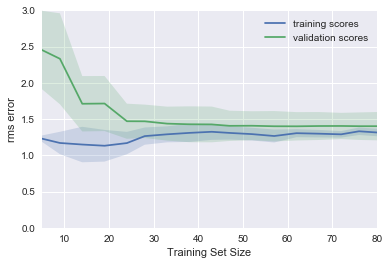

In [65]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=3):
    t_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, cv=5, train_sizes = t_sizes,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()
    print(N_train)
    
plot_learning_curve(1)

This shows a typical learning curve: for very few training points, there is a large separation between the training and test error, which indicates **over-fitting**.  Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential **under-fitting**.

As you add more data points, the training error will never increase, and the testing error will never decrease (why do you think this is?)

It is easy to see that, in this plot, if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will *never* get you there.  For $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

[ 4  9 14 19 24 28 33 38 43 47 52 57 62 67 72 76 81 86 91 96]
[ 4  9 14 19 24 28 33 38 43 47 52 57 62 67 72 76 81 86 91 96]
[ 4  9 14 19 24 28 33 38 43 47 52 57 62 67 72 76 81 86 91 96]


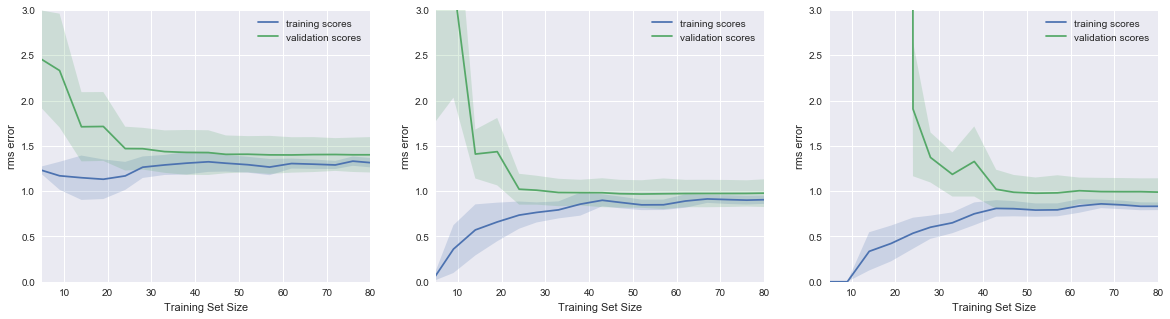

In [67]:
plt.figure(figsize = (20,5))
plt.subplot(131)
plot_learning_curve(1)
plt.subplot(132)
plot_learning_curve(3)
plt.subplot(133)
plot_learning_curve(10)

$d=3$ Here we see that by adding more model complexity, we've managed to lower the level of convergence to an rms error of 1.0!

$d=10$ For an even more complex model, we still converge, but the convergence only happens for *large* amounts of training data.

So we see the following:

- you can **cause the lines to converge** by adding more points or by simplifying the model.
- you can **bring the convergence error down** only by increasing the complexity of the model.

Thus these curves can give you hints about how you might improve a sub-optimal model. If the curves are already close together, you need more model complexity. If the curves are far apart, you might also improve the model by adding more data.

To make this more concrete, imagine some telescope data in which the results are not robust enough.  You must think about whether to spend your valuable telescope time observing *more objects* to get a larger training set, or *more attributes of each object* in order to improve the model.  The answer to this question has real consequences, and can be addressed using these metrics.